# Homework 4

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import jinja2

from scipy.stats import norm
from functools import partial
from typing import Union, List
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = "{:,.4f}".format
 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Reading the Data

In [3]:
path1 = '/Users/matheus/Desktop/finm-portfolio-2024/data/dfa_analysis_data.xlsx'
risk_free_rate = pd.read_excel(path1, sheet_name = 'factors')[['Date','RF']].set_index('Date') # take the date and RF column
factors = pd.read_excel(path1, sheet_name = 'factors').drop(columns = ['RF']).set_index('Date') # all but RF column
portfolio_total_returns = pd.read_excel(path1, sheet_name = 'portfolios (total returns)').set_index('Date')
mkt = pd.read_excel(path1, sheet_name = 'factors').drop(columns = ['SMB', 'HML', 'RF']).set_index('Date') 

### Converting total returns to excess returns in the portfolio

In [4]:
portfolio_excess_returns = portfolio_total_returns.sub(risk_free_rate.values) # total return - risk free rate (substracting the RF)

## Helper Functions

### Performance Summary

In [5]:
def summary_statistics_annualized(returns, annual_factor = 12): #returns index is date
    """This functions returns the summary statistics for the input total/excess returns passed
    into the function"""
    
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean() * annual_factor
    summary_statistics['Volatility'] = returns.std() * np.sqrt(annual_factor)
    summary_statistics['Sharpe Ratio'] = (returns.mean() / returns.std()) * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    summary_statistics['VaR (0.05)'] = returns.quantile(.05, axis = 0)
    summary_statistics['CVaR (0.05)'] = returns[returns <= returns.quantile(.05, axis = 0)].mean()
    
    return summary_statistics

### Time Series Regression

In [6]:
def time_series_regression(portfolio, factors, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid # returns a Data Frame of residuals 
            
            
        
    if resid: # returns a Data Frame of residuals 
        return bm_residuals
        
    return ff_report

### Tangency Weights

In [7]:
def tangency_weights(returns, cov_mat = 1):
    returns = returns.drop(['Date'], axis=1)

    if cov_mat == 1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag(cov))
        covmat = cov_mat * cov + (1 - cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat * 12))
    
    ones = np.ones(returns.columns.shape)
    mu = returns.mean() * 12
    scaling = 1 / (np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling * (cov_inv @ mu)
    tangency_wts = pd.DataFrame(index=returns.columns, data=tangent_return, columns=['Tangent Weights'])

    return tangency_wts

## 2. The Factors
Part 2.1

In [8]:
mkt.tail()

,Mkt-RF
Date,
2024-04-30,-0.0467
2024-05-31,0.0434
2024-06-30,0.0277
2024-07-31,0.0124
2024-08-31,0.0161


### 2.1 Calculate their univariate performance statistics:
- ### mean
- ### volatility
- ### Sharpe
- ### VaR(.05)

In [9]:
factor_summary = summary_statistics_annualized(factors, annual_factor = 12) #returns index is date
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.0822,0.1847,0.4452,-0.0793
SMB,0.0212,0.1100,0.1929,-0.0422
HML,0.0412,0.1236,0.3337,-0.0421


### Report these for the following three subsamples:
- ### Beginning - 1980
- ### 1981 - 2001
- ### 2002 - End

In [10]:
sub_1980 = factors.loc[:'1980']
sub_2001 = factors.loc['1981':'2001']
sub_2024 = factors.loc['2002':]

df_dict={'1926-1980' : sub_1980,
         '1981-2001' : sub_2001,
         '2002-2024' : sub_2024} # End year is 2024

summary_lst = []
for key in df_dict.keys():
    summary_stats = summary_statistics_annualized(df_dict[key]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary

Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                              
1926-1980 Mkt-RF  0.0811      0.2051        0.3957     -0.0840
          SMB     0.0340      0.1146        0.2966     -0.0434
          HML     0.0495      0.1338        0.3697     -0.0429
1981-2001 Mkt-RF  0.0773      0.1574        0.4908     -0.0645
          SMB    -0.0009      0.1183       -0.0073     -0.0465
          HML     0.0638      0.1112        0.5736     -0.0418
2002-2024 Mkt-RF  0.0895      0.1546        0.5787     -0.0787
          SMB     0.0110      0.0889        0.1238     -0.0391
          HML     0.0005      0.1073        0.0050     -0.0412

### 2.2) Based on the factor statistics above, answer the following.

### 2.2.a) Does each factor have a premium (positive expected excess return) in each subsample?

All 3 factors possess positive premiums in the sub period leading to 1980. 

Between 1981-2001 the Size factor (measured by the mean of SMB) provides no mean excess returns (discount of 9 basis points), but recovers to provide some premium again between 2002 and 2024.

The Value factor (measured by the mean of HML) consistently provides positive premium throughout the period of analysis. We always have positive mean excess returns for HML.

The Market factor (measured by the mean of Mkt-Rf) consistently provides positive premium throughout the period of analysis.

### 2.2.b) Does the premium to the size factor get smaller after 1980?

The premium of the size factor (SMB) fell after 1980, and slightly rose again from 2002 and on. This reflects the case narrative, in which small stocks suffered as a result of the 1980s recession. It is important to note that Fama and French showed that this underperformance was more the result of poor fundamentals in smaller firms rather than them having "fallen out of favor" in the market. This seems to reinforce the notion that smaller stocks are riskier and should thus require a premium.

### 2.2.c) Does the premium to the value factor get smaller during the 1990's?

The premium to value factor increases in the sub-sample of 1981-2001 as compared to 1926-1980, but then experiences a significant decline post the 2002 internet bubble burst and having almost 0 excess returns till 2024. The premium to value factor increases from 4.95% in 1926 - 1980, to 6.38% in 1981-2001.

The tech bubble in the late 1990s and early 2000s had a huge influence on the spread, as the value factor experienced significant drawdowns, with tech stocks trading at levels far from fundamentals. In general, the value factor traded at a negative spread — a logical result, since the long portfolio is always cheaper than the short. 

Source - https://blogs.cfainstitute.org/investor/2017/09/12/there-is-value-in-the-value-factor/

### 2.2.d) How have the factors performed since the time of the case, (2002-present)?

Since 2002, the size factor has been positive (SMB) and the value factor (HML) has been very close to zero. Put otherwise, small cap has "outperformed" large cap and growth has performed equally as well as has value.

### 2.3) The factors are constructed in such a way as to reduce correlation between them. 

### Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? 

Overall, the correlations between the three factors are low and thus the construction method succeeds in its objective. The Size and Value factors have very low correlations with each other, but are still relatively more correlated to the market factor.

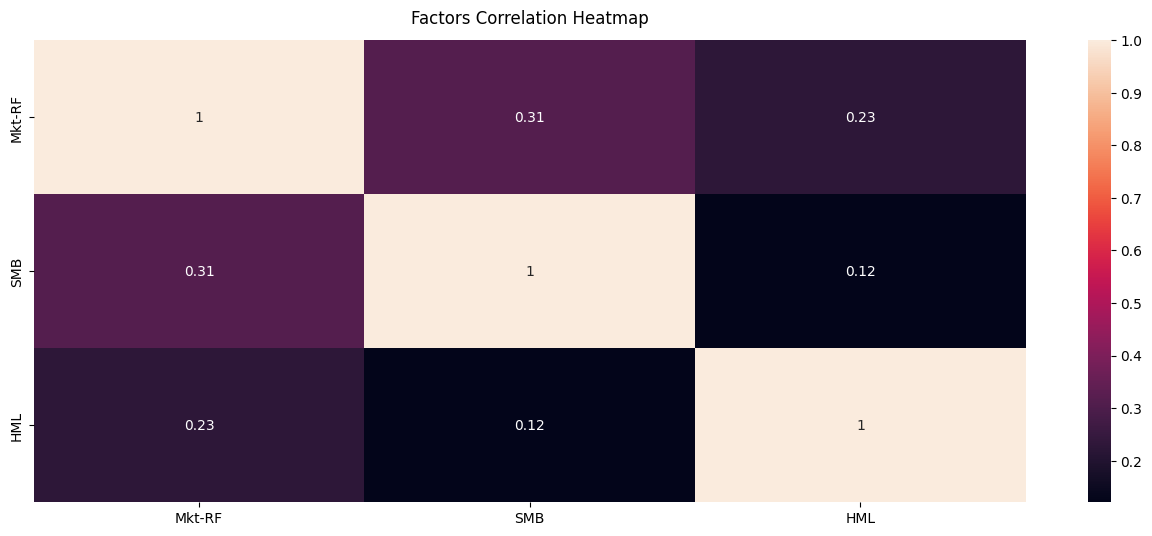

In [11]:
fig, ax = plt.subplots(figsize=(16,6))
correlation_matrix = factors.corr()
sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns, 
            yticklabels=correlation_matrix.columns, annot=True).set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Does it achieve this in each subsample?

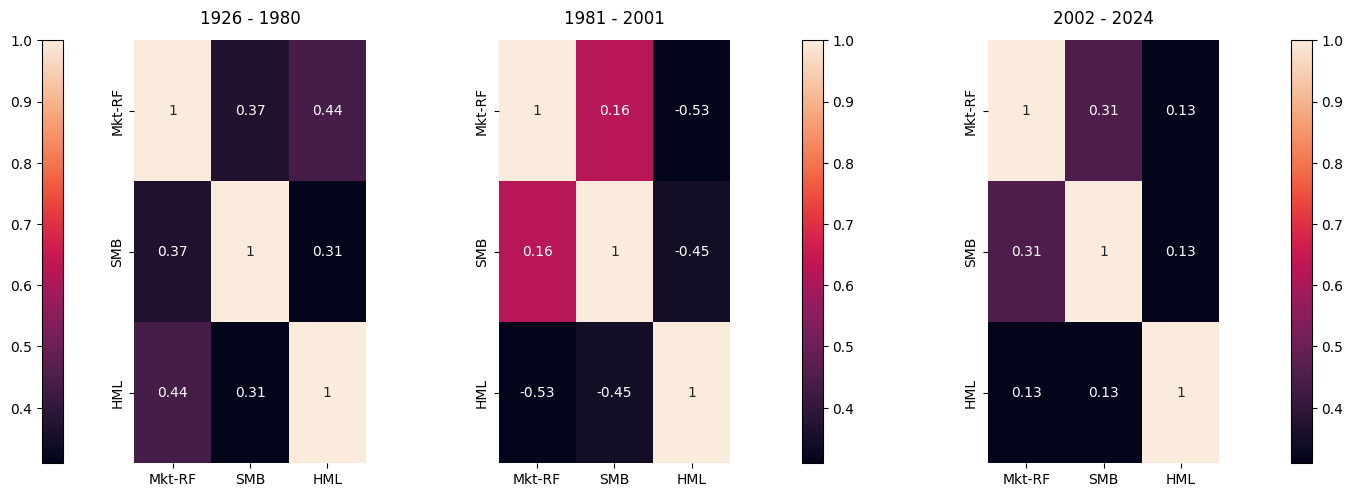

In [12]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)

sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2024.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2024', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

These correlations are somewhat far from being small, however in general the factors due indeed seem to be not very correlated (less than 50% in most cases). The correlation of the value and size factors is smallest, and the correlations of each factor to the market is slightly larger. We see these correlations vary quite significantly through the various subsamples, as seen in the above correlation matrices. We note that in general it is very difficult to find assets or portfolios that have lower (or negative) correlation with the market.

### 2.4) Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

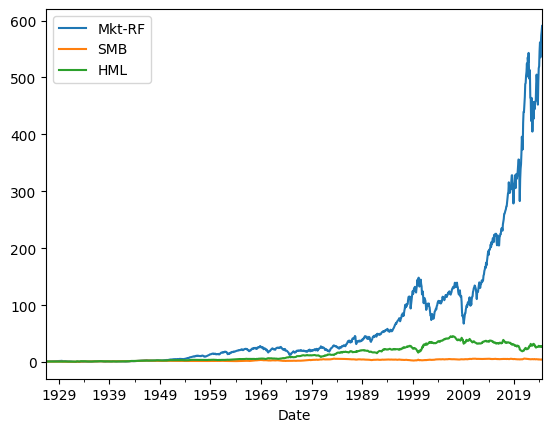

<Figure size 1500x700 with 0 Axes>

In [13]:
figure = ((factors + 1).cumprod()).plot()
plt.figure(figsize=(15, 7))
plt.show()

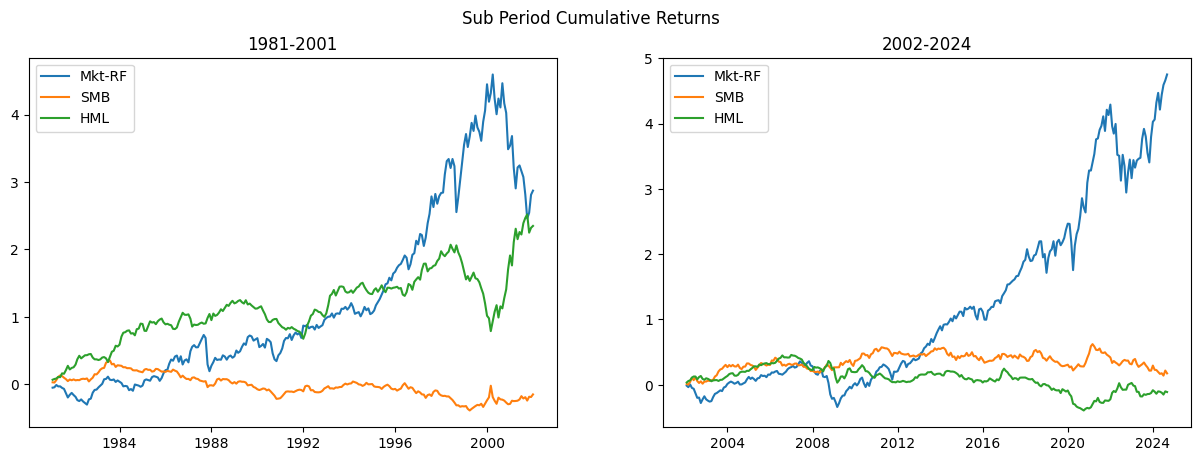

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2024 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_2024.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2024')

### 2.5) Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

As per the graphs above, it appears that the market risk factor was valuable in both sub-samples. However, the Market Factor sees a steep decline with the Tech bubble burst in late 2001, during which time the value factor benefits from the depressed stock prices to post a premium. The Size factor posts near zero or negative returns for the entire sub-sample of 1981-2001. 

With a good recovery post the Tech Bubble burst and similar bull run post the 2008 financial crisis, the Market-factor significantly outperforms Size and Value in the 2002-2024 sub-sample. Both Size and Value factor post meagre returns during this period, with the value factor experiencing declining premiums as companies traded further away from their fundamentals. This Value factor might still be beneficial given its diversification effects.

Though all 3 factors still possess some relevant characterisitics, it appears that Factor rotation might be a better strategy in hindsight. The size factor seems out of favor for a long time now and the returns seem correlated to the Market Factor. DFA should also try to explore other factors such as volatility, liquidity, momentum etc. to generate alpha while sticking to their belief of capital markets being efficient.

## 3. CAPM

#### DFA believes that premia in stocks and stock portfolios is related to the three factors. Let's test 25 equity portfolios that span a wide range of size and value measures

- #### PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as $r^{i}$, for n = 1,....,25.
- #### Note that while the factors were given as excess returns, the portfolios are total returns.
- #### For this entire problem, focus on the 1981-Present subsample.

### 3.1) Summary Statistics.

### For each portfolio,

- ### Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- ### Calculate the (annualized) univariate statistics from 1.1.

In [15]:
port_summary = summary_statistics_annualized(portfolio_excess_returns.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.0067,0.2738,0.0244,-0.1261
ME1 BM2,0.0887,0.2364,0.3752,-0.0947
ME1 BM3,0.0920,0.2013,0.4572,-0.0862
ME1 BM4,0.1160,0.1943,0.5971,-0.0770
SMALL HiBM,0.1278,0.2100,0.6086,-0.0885
ME2 BM1,0.0589,0.2452,0.2401,-0.1041
ME2 BM2,0.1005,0.2055,0.4891,-0.0857
ME2 BM3,0.1059,0.1858,0.5703,-0.0785
ME2 BM4,0.1088,0.1821,0.5977,-0.0761
ME2 BM5,0.1160,0.2156,0.5380,-0.0964


### Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

Based on the scatter plots below, we do not get a clear indication if the differences in the mean excess returns are explained by differences in either their VaR or their Volatility. Given VaR is a factor of portfolio volatility, and that higher volatility results in a higher VaR threshold, the return differences might be explained slightly by the differences in the volatility. A linear pattern can be observed between volatility and mean excess returns to support the previous arguments, but the evidence is not very concrete from the plots below.

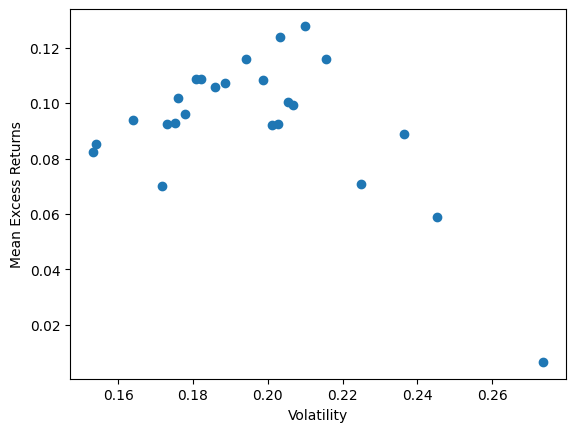

In [16]:
# X axis = volatility, Y axis = Mean of each portfolio
plt.scatter(port_summary.loc[:,['Volatility']],port_summary.loc[:,['Mean']])
plt.xlabel("Volatility")
plt.ylabel("Mean Excess Returns");

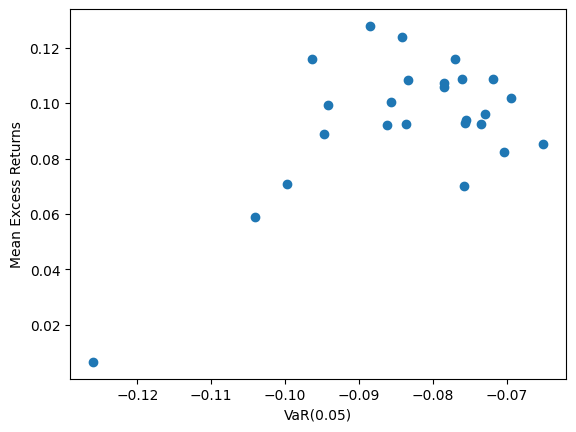

In [17]:
plt.scatter(port_summary.loc[:,['VaR (0.05)']],port_summary.loc[:,['Mean']])
plt.xlabel("VaR(0.05)")
plt.ylabel("Mean Excess Returns");

### 3.2 CAPM

#### The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)
#### Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{m}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{m}$.

#### <center>$$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}]$$</center>
#### Let's examine whether that seems plausible.


### 3.2.a) For each of the n = 25 test portfolios, run the CAPM time-series regression. So you are running 25 separate regressions, each using the T-sized sample of time-series data. Report the betas and alphas for each test asset.

### 3.2.c) Report the estimated βi,m, Treynor Ratio, αi, and Information Ratio for each of the n regressions.

In [18]:
ts_CAPM = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'], resid=False) # only against market premium
ts_CAPM

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.1067,1.3564,-0.6134,0.0049,0.5961,0.1740
ME1 BM2,-0.0088,1.1657,-0.0580,0.0761,0.5905,0.1513
ME1 BM3,0.0046,1.0452,0.0391,0.0880,0.6550,0.1182
ME1 BM4,0.0347,0.9725,0.2854,0.1193,0.6085,0.1216
SMALL HiBM,0.0447,0.9950,0.3151,0.1285,0.5450,0.1417
ME2 BM1,-0.0530,1.3386,-0.4119,0.0440,0.7240,0.1288
ME2 BM2,0.0056,1.1349,0.0538,0.0886,0.7405,0.1047
ME2 BM3,0.0199,1.0286,0.2124,0.1030,0.7445,0.0939
ME2 BM4,0.0273,0.9747,0.2722,0.1117,0.6957,0.1004
ME2 BM5,0.0228,1.1144,0.1786,0.1041,0.6487,0.1278


### 3.2. b) Report the mean-absolute-error of the CAPM

In [19]:
# Mean-absolute-error of the CAPM
MAE = pd.DataFrame([(((ts_CAPM['alpha_hat']).abs().mean()))], columns = ['MAE'], index = ['CAPM'])
MAE

,MAE
CAPM,0.0224


If CAPM were true, the Mean Absolute Error (MAE) should be 0. CAPM assumes that the portfolio's return is fully explained by its exposure to market risk (beta) and the market risk premium. If this assumption is true, the return of the portfolio would align perfectly with what the model predicts, leaving no errors (residuals). But evidently, MAE is not explicitly 0, which means there is some residuals such that not all of the portfolio's return can be explained by the market risk premium.

### 3.2.d) If CAPM were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If CAPM were true, we would observe **same** Treynor ratios for all 25 portfolios as the portfolio returns should completely be a function of market returns (SPY). However, as we observe, most portfolios have varying Treynor ratios, indicating towards a high alpha and/or low regression beta. 

The alphas should similarly have been lower (ideally 0) for all portfolios and we should have also seen low absolute magnitude of the residuals, resulting in lower (ideally 0) information ratios. But we observe, that the alphas are still higher than expected and the Information ratios are higher than expected indicating towards presence of other regressors that should be included in the model.

## 3. Cross-sectional Estimation
(a) Report the R-squared of this regression. <br>
(b) Report the intercept, η.<br>
(c) Report the regression coefficient, λm.<br>

In [20]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, ts_CAPM['beta_mkt'])

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.2086,-0.0090,35.4047,-10.4114,0.3006,0.0059


The intercept is alpha_hat. The regression coefficient is beta_mkt. The R-squared here is not good, only 30% of prediction power.

###  What would these three statistics be if (CAPM) were true?

In general, if CAPM were true, we should find a few things. First, the $R^{2}$ should be extremely high, as our dependent variable (portfolio *mean* returns) should be explained entirely by the level of market risk taken on (the $\beta$ we estimated in the prior regressions), which is our regressor in this case. In addition, the coefficient $\lambda_{m}$ should equal the market premium. Lastly, the intercept term should be 0, reflecting that one should not get any excess mean returns if they take no market risk.

### 3.4) Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the CAPM?

Low R-Squared and betas, and higher alpha from the cross-sectional regression in the previous question, indicates the presence of other risk factors in the market that can explain excess returns of equity portfolios. Also, as shown by the Fama-French paper, size and value have posted premiums in the past and thus can be used to explain mean excess returns in better capacity than CAPM alone. These results do support DFA's belief in size and value portfolios containing premia unrelated to CAPM.

Using Size and Value as additional factors in the regression for the 25 portfolios, we see a higher R-Squared in the regression, further strengthening DFA's belief in existence of premia in Value and Size Factors

# 4) Extensions

### 4.1) Re-do the analysis of 3.3 and 3.3, but instead of using the market return as the factor, use a new factor: the in-sample tangency portfolio of the n = 25 portfolios.

In [21]:
w_t = tangency_weights(portfolio_excess_returns['1981':].reset_index())
TangencyPort_df = pd.DataFrame(w_t,columns= ["Tangent Weights"],index=port_summary.index)
TangencyRets = (portfolio_excess_returns @ TangencyPort_df).rename(columns={'Tangency Portfolio Weight':'Tangency Returns'})
tangency_ts = time_series_regression(portfolio_excess_returns.loc['1981':], TangencyRets.loc['1981':],False)
tangency_ts

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,0.0000,0.0174,0.0000,0.3830,0.0002,0.2737
ME1 BM2,0.0000,0.2315,0.0000,0.3830,0.0413,0.2315
ME1 BM3,0.0000,0.2402,0.0000,0.3830,0.0613,0.1950
ME1 BM4,0.0000,0.3028,0.0000,0.3830,0.1046,0.1838
SMALL HiBM,0.0000,0.3338,0.0000,0.3830,0.1087,0.1983
ME2 BM1,0.0000,0.1537,0.0000,0.3830,0.0169,0.2431
ME2 BM2,0.0000,0.2624,0.0000,0.3830,0.0702,0.1982
ME2 BM3,0.0000,0.2766,0.0000,0.3830,0.0954,0.1767
ME2 BM4,0.0000,0.2841,0.0000,0.3830,0.1048,0.1723
ME2 BM5,0.0000,0.3028,0.0000,0.3830,0.0849,0.2063


In [22]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, tangency_ts.loc[:,['beta_mkt']], False)

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.0000,0.0319,6.8754,2.9407,1.0000,0.0000


We note that the intercept term is 0, and although the betas of each portfolio to the tangency portfolio differ we find that their Treynor ratios are all the same! This is exactly what we would expect to find if this model was valid. 

So is this model valid?

The cross-sectional regression validates what we previously discovered -- the model is a perfect fit. Again, we care to have a high $R^2$ value and an intercept equal to zero.

### 4.2) Re-do the analysis of 3.3 and 3.4, but instead of using the market return as the factor, use all three factors, (MKT, SMB, and HML). Note again that all three are already given as excess returns, so there is no need to use the risk-free rate data.
### Thus, instead of testing (CAPM), you will be testing the Fama-French 3-Factor Model.

In [23]:
ts_FF3F = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':],True)
ts_FF3F

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.0858,1.1118,1.3925,-0.2538,-0.9375,0.0060,0.8882,0.0915
ME1 BM2,0.0014,0.9655,1.3177,-0.0144,0.0203,0.0919,0.9109,0.0706
ME1 BM3,0.0006,0.9231,1.0651,0.2774,0.0120,0.0997,0.9393,0.0496
ME1 BM4,0.0222,0.8778,1.0658,0.4774,0.4673,0.1321,0.9403,0.0475
SMALL HiBM,0.0231,0.9298,1.0660,0.6914,0.3120,0.1375,0.8763,0.0739
ME2 BM1,-0.0324,1.1419,1.0233,-0.3103,-0.5395,0.0516,0.9399,0.0601
ME2 BM2,0.0072,1.0138,0.9159,0.1213,0.1412,0.0991,0.9393,0.0506
ME2 BM3,0.0087,0.9740,0.7192,0.3892,0.1656,0.1088,0.9208,0.0523
ME2 BM4,0.0084,0.9413,0.7483,0.5751,0.1861,0.1156,0.9390,0.0450
ME2 BM5,-0.0058,1.0892,0.9298,0.8328,-0.1243,0.1065,0.9536,0.0464


In [24]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')
time_series_regression(portfolio, ts_FF3F.loc[:,['beta_mkt','Size beta','Value beta']], True)

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.1865,-0.0083,-0.0002,0.0029,36.1123,-11.2427,0.4628,0.0052


The FF3F model improves the CAPM marginally as shown by the higher $R^2$ and the slightly smaller intercept term. Even so, it appears there are some dynamics that this model is not capturing, at least in our given sample.

### 4.3.a) Report the mean-absolute-error of the CAPM:

In [25]:
pd.DataFrame([(((ts_FF3F['alpha_hat']).abs().mean()))], columns = ['MAE'], index = ['CAPM'])

,MAE
CAPM,0.0145


The intercept terms (and MAE) are much smaller than we found previously (when testing CAPM). The Treynor ratio, which in this case is still only with respect to the market betas, still differs across assets. Note that the interpretation of Treynor ratio is different now that we have multiple factors.

### 4.3.b) Under classic statistical assumptions, we can test the null hypothesis that the CAPM works by calculating,

In [26]:
resid = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'], False, True)

In [27]:
T = portfolio_excess_returns['1981':].shape[0]
SR = factors['1981':]['Mkt-RF'].mean() *12/ factors['1981':]['Mkt-RF'].std()*np.sqrt(12)
Sigma = resid.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = ts_CAPM['alpha_hat']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

H = 472.07
p-value = 0.0000


### 4.3.c) Which is a stricter test: checking whether any of the n values of $\alpha^{i}$ have a statistically significant t-test or checking whether H calculated above is significant?

- By definition, a joint test is stricter than testing the conditions individually. Therefore, the stricter test is checking whether $H$ is significant. 

- In our case, we can see that most of the alphas are not significant, evidence that CAPM holds,  while some alphas are signficant as judged by their individual t-stats, yet all of them are jointly significant as judged by this joint test. However, the H statistic indicates CAPM does not hold (small p-value, we reject the null hypothesis).

### 4.3.d) Conceptually, how does the test-statistic H relate to checking whether $\tilde{r}^{m}$ spans the tangency portfolio?
- We have demonstrated that an LFM is exactly the same as asserting that a set of factors spans the MV frontier, (and thus spans the tangency portfolio.) 
- Thus, this test can be interpreted as checking whether investing in the alphas gets beyond the tangency portfolio. The test stat is basically comparing the square SR of the alphas to the square SR of the factors.

This year's answer: 

Conceptually, we are checking to what extent the alphas (which are the mean returns that the factors *cannot explain*) capture the MV characteristics of the portfolios compared to the risk factor. In "totality", the MV characteristics are given by the tangency portfolio. As such, alpha values of zero would imply that the risk factor completely captures everything (implying the risk factor *is* the tangency portfolio) and alpha values that are non-zero would imply that the risk factor does not capture it. In other words, we are assessing whether the risk factors replicate (or span) our tangency portfolio.